# IIVP - Project 1
### 6252320 - Leon Debnath

Import the required modules for the notebook

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from skimage.util import random_noise

Due to the amount of image plotting required, a helper function was used to abstract the display of images into a single `display()` function that takes a list of images and corresponding labels.

In [176]:
def display(images, labels, axis='off', cmap=None):
    
    if len(images) != len(labels):
        raise Exception("images and labels don't correspond")
        
    fig = plt.figure(figsize=(15,10))
    cols = 2
    rows = math.ceil(len(images)/2)
    
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(labels[i])
        plt.axis(axis)

## Exercise 1 - Colour Spaces

### a. RGB to HSV
Initially the images were loaded using the Open Source Computer Vision library cv2 (in BGR), and were converted to the RGB colour space. 

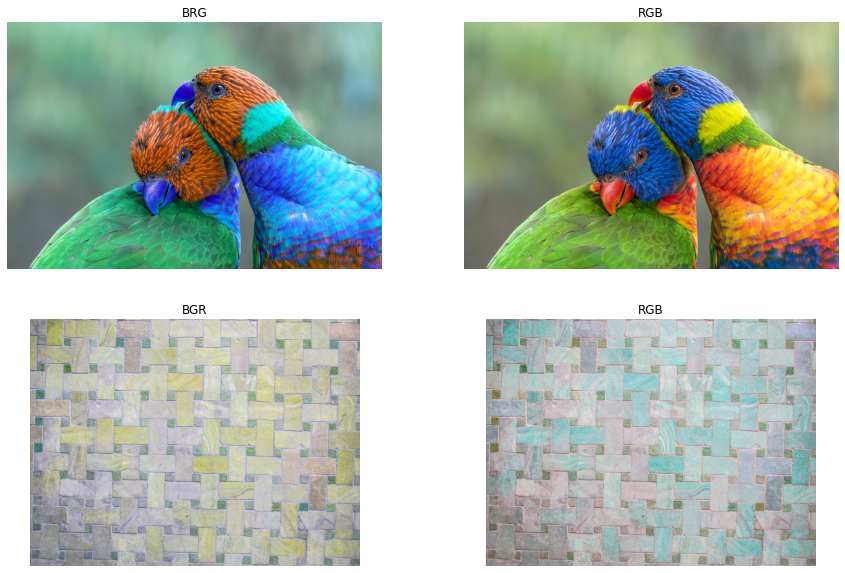

In [177]:
from functions import rgb2hsi, rgb2hsv

img1_bgr = cv2.imread('images/birds.jpg')
img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_bgr = cv2.imread('images/stone.jpg')
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

display([img1_bgr, img1_rgb, img2_bgr, img2_rgb], ['BRG', 'RGB', 'BGR', 'RGB'])

The **RGB** colour space uses three values in the range $\{0 - 255\}$ for the primary colours; **red**, **green**, and **blue**, which are additively combined into the final colour.  Alternatively **HSV/HSI** use the combination of a **hue** (a $360^{\circ}$ angle that rotates through all of the visible colours), a level of colour **saturation**, and the **value** or **intensity** respectively

To convert from RGB to HSV, the following set of formulae can be used ([1](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)):

**Value:**
$$ 
\begin{equation}
V = max(R, G, B)
\end{equation} 
$$
**Saturation:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$
**Hue:**
$$
\begin{matrix}
      & \frac{60 \cdot (G - B)}{V - min(R,G,B)} & \text{  if } V = R  \\
 H =  & \frac{120 + 60 \cdot (B - R)}{V - min(R,G,B)} & \text{  if } V = G  \\
      & \frac{240 + 60 \cdot (R - G)}{V - min(R,G,B)} & \text{  if } V = B  \\
      & 0 & \text{ if } R = B = G
\end{matrix}
$$

**N.B.** $S_v$ represents the saturation for HSV colour space 

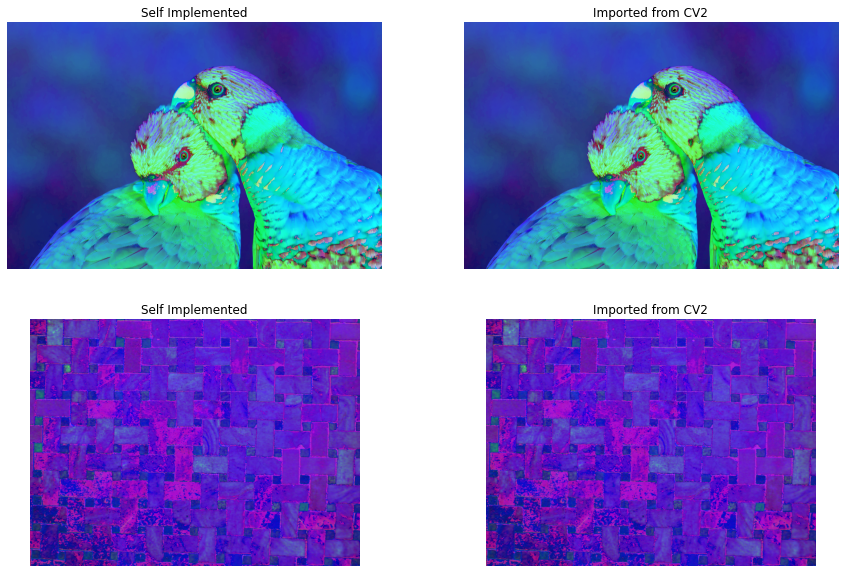

In [178]:
img1_imp_hsv = rgb2hsv(img1_rgb)
img1_cv2_hsv = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2HSV)
img2_imp_hsv = rgb2hsv(img2_rgb)
img2_cv2_hsv = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2HSV)

display([img1_imp_hsv, img1_cv2_hsv, img2_imp_hsv, img2_cv2_hsv], 
        ['Self Implemented', 'Imported from CV2', 'Self Implemented', 'Imported from CV2'])

Each of the images rendered in HSV shows clearly the difference in chroma that initially were difficult to distinguish.  This is particularly clear on the second image, a faded stone in pastle blue and pink.  The low intensity of the RGB image makes the colours seem to fade together to the human eye.  In the HSV space, as the chroma and value are encoded on seperate channels, the red areas indicate a clear colour change, while the blue areas of the image show the value (or lightness) of the image. 

Given the lack of almost any green in the second set of images, we can discern that the image is incredibly faded with a very low level of saturation encoded into the green channel of RGB.  The image of the birds, showing vibrant colours in a very high intensity in the foreground displays the greens expected of a highly saturated image.

In [179]:
print(img1_imp_hsv.shape)

(3836, 5808, 3)


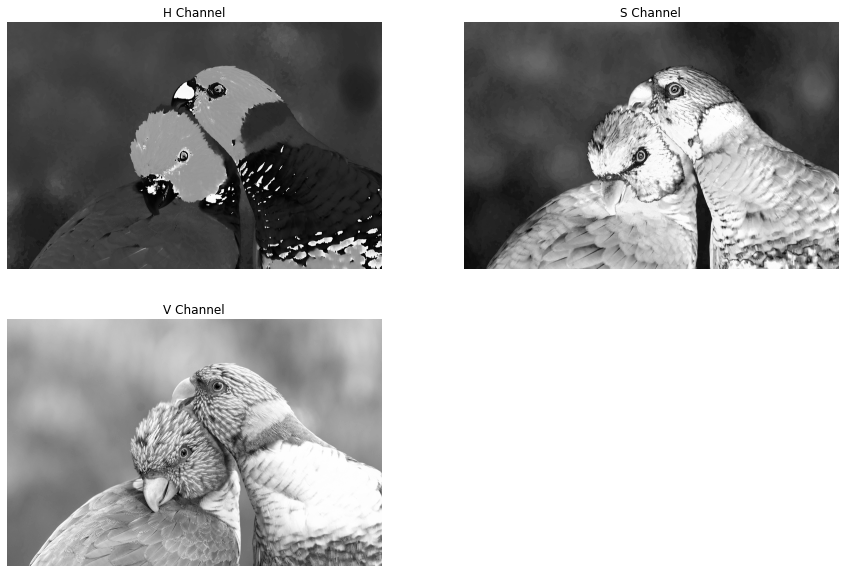

In [180]:
display([img1_imp_hsv[:,:,0], img1_imp_hsv[:,:,1], img1_imp_hsv[:,:,2]], 
        ['H Channel', 'S Channel', 'V Channel'], cmap='gray')


### b. RGB to HSI

The HSV and HSI models both use the same value for Hue as calculated in the formula above.  The saturation differs as shown below for the HSI model, with intensity replacing value:

**Intensity**

$$
\begin{equation}
    I = \frac{V_{max} + V_{min}}{2}
\end{equation}
$$

**Saturation**

$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \gt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \le 0.5   
\end{matrix}
$$

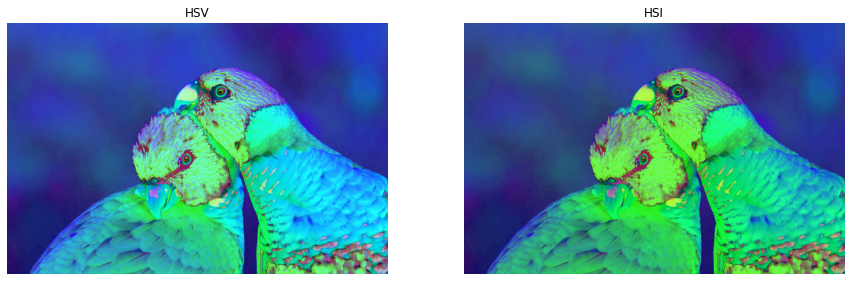

In [181]:
img1_imp_hsi = rgb2hsi(img1_rgb)

display([img1_imp_hsv, img1_imp_hsi], ['HSV', 'HSI'])

Observe that the HSI image more clearly identifies the areas of high saturation in areas of the image. This can be intuitively understood by contrasting the saturation calculations for HSV and HSI against eachother. 

**HSV:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$

**HSI**
$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \lt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \ge 0.5   
\end{matrix}
$$

HSV takes the minimum value of the three RGB channels from the total value and then normalises by the value (if not equal to zero).  As $V=max(R, G, B)$ this essentially takes the highest to lowest value range and scales it by the max value.  For a deep RGB blue (10, 20, 255) this would give a saturation value of 0.96 while in the HSI colour space this would be 1 as the largest difference is scaled by the total of the min and max values; thus RGB to HSI conversion highlights saturation more clearly.

## Exercise 2 - Pointwise Transforms & Histogram Equalisation

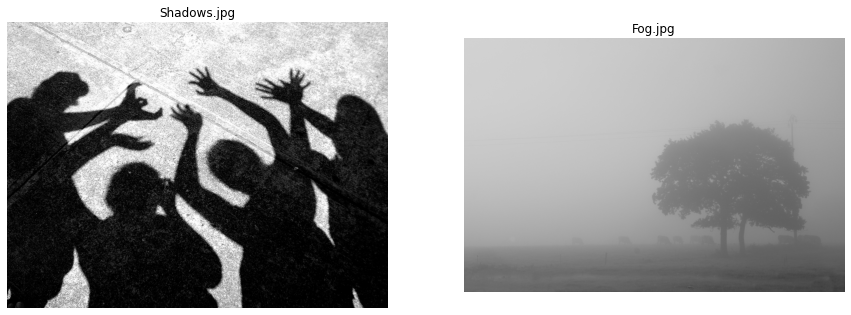

In [182]:
from functions import histogram, contrast 

img1 = cv2.imread('images/shadows.jpg')
img2 = cv2.imread('images/fog.jpg')

display([img1, img2], ['Shadows.jpg', 'Fog.jpg'])

### a. Greyscale Distribution

Two greyscale images are shown, comprising of a 2 dimensional array of values ranging from $(0 - 255)$ with higher values indicating darker pixels.  By iterating over each value in the array and summing up the total number of times each value is encountered, a histogram can be formed with 255 bins.  

The distribution of the `Fog` image, containing mainly low intensity greys is expected to show a distribution weighted around the centre of the greyscale spectrum.  With few, if any, very light or very dark points, it is expected there will be almost nothing in the 0 and 255 sections of the histogram.

Conversely, the sharp contrast of dark and light parts of the `Shadows` image will show spikes at the two extremes with very little in the centre section of the plot.

In [183]:
data_img1 = histogram(img1)
data_neg1 = histogram(np.subtract(255, img1))
data_img2 = histogram(img2)
data_neg2 = histogram(np.subtract(255, img2))

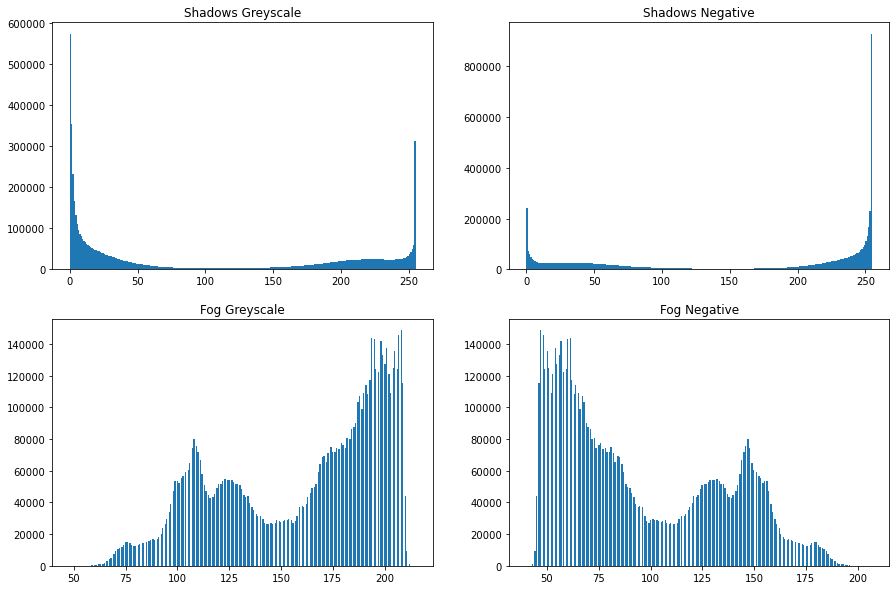

In [184]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.hist(data_img1, bins=255)
plt.title('Shadows Greyscale')

plt.subplot(2, 2, 2)
plt.title('Shadows Negative')
plt.hist(data_neg1, bins=255)

plt.subplot(2, 2, 3)
plt.title('Fog Greyscale')
plt.hist(data_img2, bins=255)

plt.subplot(2, 2, 4)
plt.title('Fog Negative')
plt.hist(data_neg2, bins=255)

plt.show()

### b. Negative Pointwise Transform

By applying a negative pointwise function to each pixel (assigning to each pixel the inverse of the pixel value $v$ such that $v \gets (255 - v)$) the inverse of the image can be generated.  The inverse images can are shown below, with the dark portions of the `Shadows` image becoming bright white, as with an analogue photo negative.  This can also be observed in the histograms above, where the distribution of values is inverted along the centerpoint of the $x$-axis around the point where $x = \frac{255}{2}$.

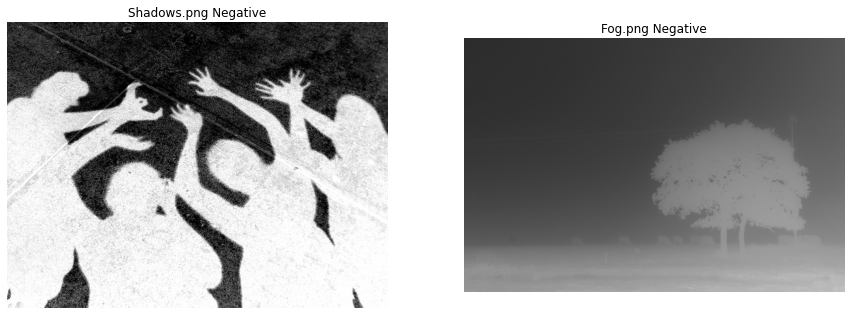

In [185]:
img1_neg = np.subtract(255, img1)
img2_neg = np.subtract(255, img2)
display([img1_neg, img2_neg], ['Shadows.png Negative', 'Fog.png Negative'])

### c. Negative Histograms

Note two phenomena within the histograms; firstly the negative `shadows` image has a spike around bin 255, double that of the original (some 4000 occurances compared to less than 2000 in the original), where presumeably a rounding issue is causing the values at the extreme end of the spectrum to be inverted and then rounded to a different bucket.  An attempt at correcting for this was made, by rounding to the nearest integer before inverting, however this did not significantly effect the histogram.  Reducing the number of buckets by a factor of $1/2$ removed this error.

Secondly, the Fog image has regularly spaced gaps within its histogram, as entire light levels are completely absent this is hypothesised to be the after effect of a compression algorithm or of a poor original image as a regular pattern of one wide gap followed by three small gaps can be clearly observed within the plot and is unlikely to be a natural phenomenom. 

### d. Power Law Transform

The contrast of the images can be modified by applying the rule $s \gets r^{n}$ (where $r$ and $s$ are the original and modified pixel values respectively) pointwise to correct the differences between the way that a camera captures images (taking the abolute value of photons entering the receiver) and the way that humans perceive light, where the differences are discrimiated to a greater extent depending on the intensity of the surrounding area of the image.

A more controllable, non-linear, method was used as an alternative to $s = r^{n}$ in the form of Gamma correction.  The constant $\gamma$ was used to set the amount of constrast required using the formula $s = r^{\frac{1}{\gamma}}$.

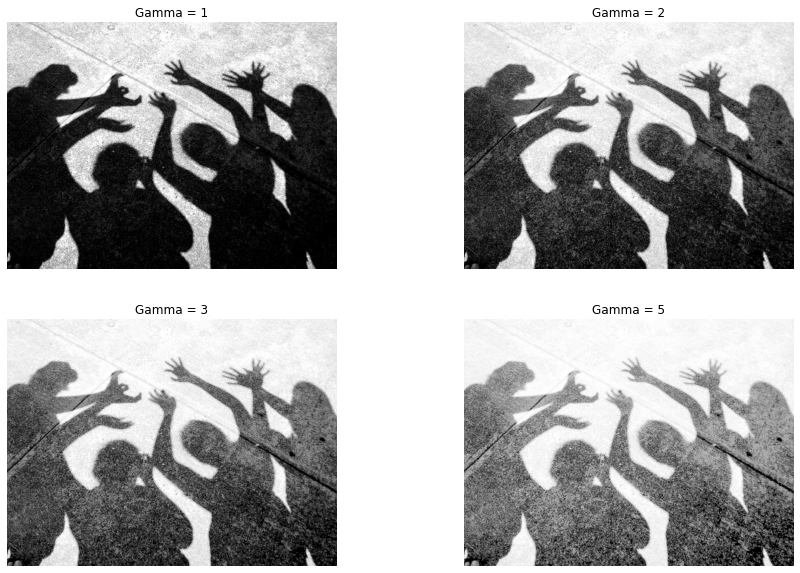

In [186]:
display([contrast(img1,1),
         contrast(img1,2),
         contrast(img1,3),
         contrast(img1,5)],
        ['Gamma = 1',
         'Gamma = 2', 
         'Gamma = 3',
         'Gamma = 5'])

Observe that the use of a high gamma value can help reduce the contrast of the `Shadow` image revealing the cracks and undulations of the pavement under the peoples' shadows.  Here a gamma of $\gamma = 1$ returns the original image.  As the gamma is increased, the image becomes more faded in very light areas, with pixels converging on either very high or low values.

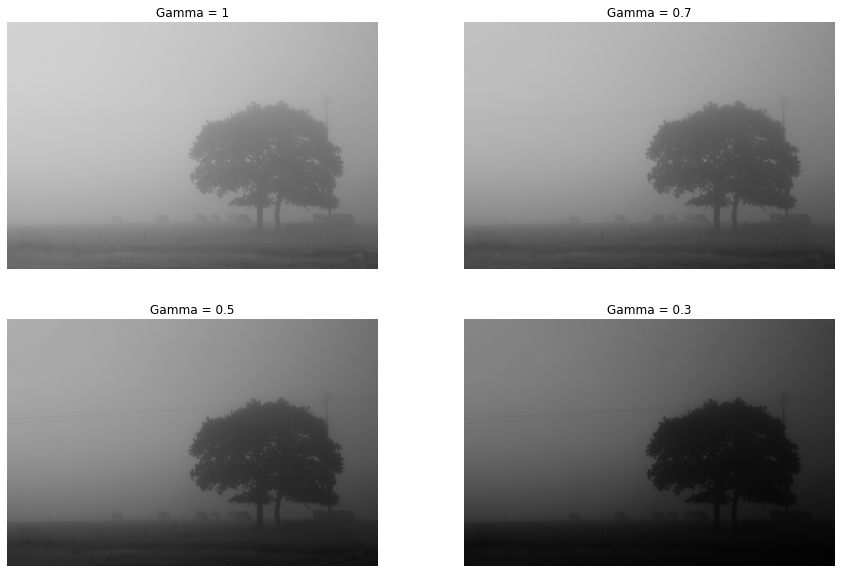

In [187]:
display([contrast(img2,1),
         contrast(img2,0.7),
         contrast(img2,0.5),
         contrast(img2,0.3)],
        ['Gamma = 1',
         'Gamma = 0.7', 
         'Gamma = 0.5',
         'Gamma = 0.3'])

Alternatively reducing the gamma value can allow for previously indistinguishable details to become apparent in largely homogenous grey areas, such as the power lines and animals in the `Fog` image above.

## Exercise 3 - Special Effects

### a. Polar Coordinates
Each pixel in the images we see are plotted on a cartesian plane where a value is stored against its vector location based on the distance $(x, y)$ from the point $(0,0)$.  An alternative vector space can be used by storing the location of each value against the angle ($\theta$) and the distance from the centre ($\rho$).  These are equivalent ways of describing the same space as shown below.([2](https://en.wikipedia.org/wiki/Polar_coordinate_system))   

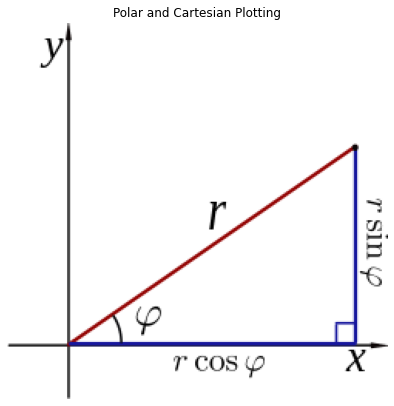

In [188]:
display([cv2.imread('images/Polar_to_cartesian.png')],['Polar and Cartesian Plotting'])

Converting from cartesian to polar coordinates can be done simply using the following formulae:

$$
\begin{equation}
\rho = \sqrt{x^2 + y^2}
\end{equation}
$$

$$
\begin{equation}
\theta = \text{atan2}(y, x)
\end{equation}
$$

OpenCV provides a function `linearPolar`  that can be used to convert the image coordinates. ([3](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gaa38a6884ac8b6e0b9bed47939b5362f3))

In [189]:
def polar(img):
    value = np.sqrt(((img.shape[0] / 2.0) ** 2.0) + ((img.shape[1] / 2.0) ** 2.0))
    polar_image = cv2.linearPolar(img, (img.shape[0] / 2, img.shape[1] / 2), value, cv2.WARP_FILL_OUTLIERS)
    return polar_image.astype(np.uint8)

When these polar images are plotted, they are plotted on the cartesian plane of a computer screen, with their polar coordinates.  This causes the circular geometric patterns eminating from the centrepoint to be plotted horizontally.  Intuitively we can think of the polar image as showing the distance from the centrepoint of the cartesian image.  Thus four "spikes" form at the far right of the polar image, corresponding with the four corners of the cartesian image that are the furthest from the centre (a circular cartesian image would produce a single verticle line in this case).  It should also be noted that the centre of the cartesian image is stretched out to fill the entirety of the left side of the polar image, this is due to the small distances between angles at the centre of the image.

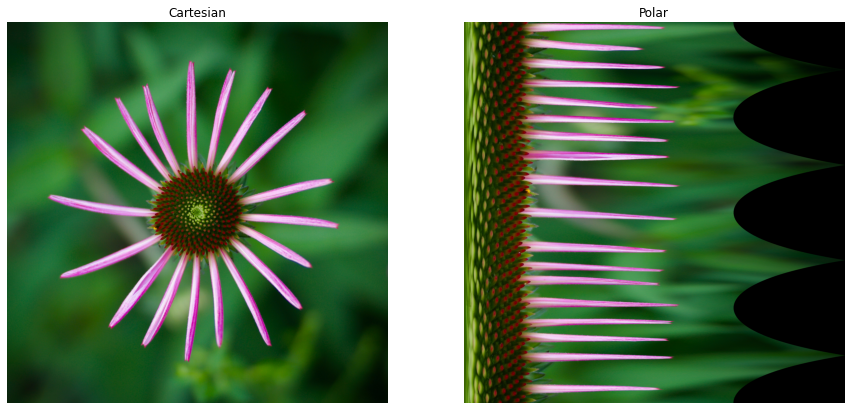

In [190]:
flower = cv2.imread('images/flower.jpeg')
flower = cv2.cvtColor(flower, cv2.COLOR_BGR2RGB)
display([flower, polar(flower)],['Cartesian', 'Polar'])

An off-centre, or oblong cartesian image causes two further effects, the first that the four corner spikes in the are not evenly distanced as the image is not of a perfect square.  Secondly, as the centrepoint is slightly south of the centre of the door's window, the unwrapping of the window into a linear shape is not symetrical, causing a Salvador Dali-esque melting effect on the shape depicted.

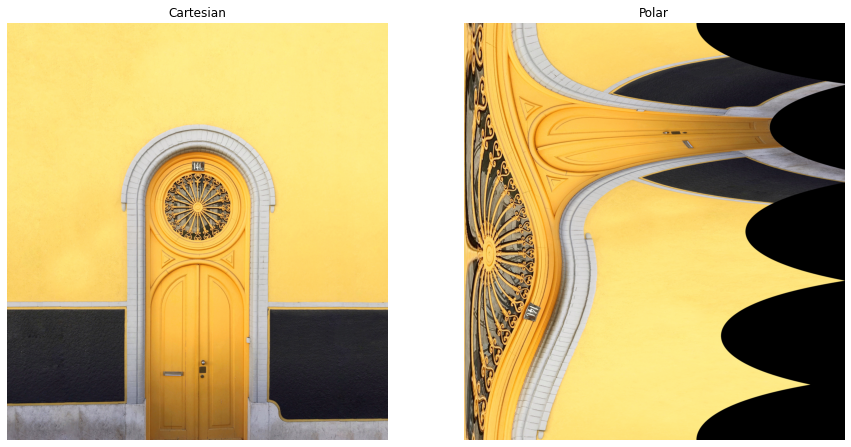

In [191]:
door = cv2.imread('images/door.jpeg')
door = cv2.cvtColor(door, cv2.COLOR_BGR2RGB)
display([door, polar(door)],['Cartesian', 'Polar'])

### b. Cartoonify
To "cartoonify" the images initially a filter was used to detect edges([4](https://medium.com/nerd-for-tech/cartoonize-images-with-python-10e2a466b5fb)).  This involves applying a convolution with a gaussian filter kernel to smooth out the image followed by laplacian filter to identify derivative changes at different angles.  Finally two threshold values are set (a high and low threshold) within which the pixel must fall to be encoded 'high' in the output image.  This gives an output of all of the edges in the image with a single colour background, almost like a pencil sketch.

Secondly a K-means algorithm was applied to quantise the image into a certain number of colours to provide homogenised background colours.  Finally the edges and quantised images were combined with a bitwise AND function to give the effect of a cartoon-esque drawing of the original image.

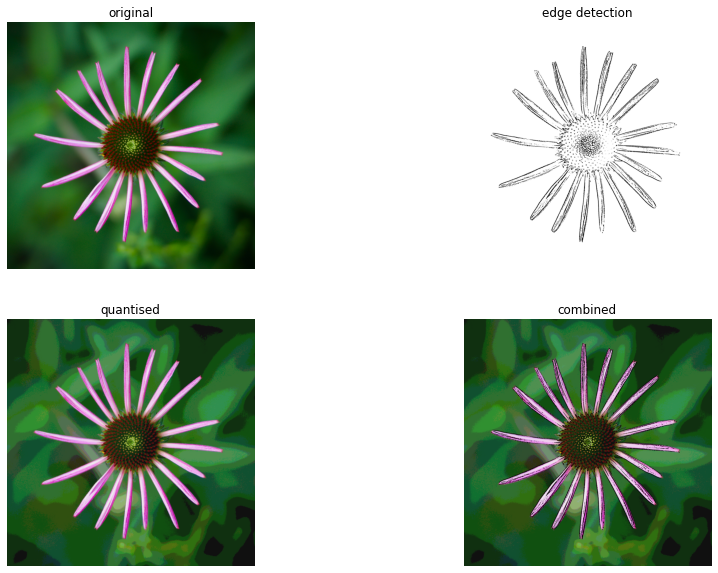

In [192]:
from functions import cartoonify

edges, quantise, combined = cartoonify(flower, 8)
display([flower, edges, quantise, combined], ['original', 'edge detection', 'quantised', 'combined'])

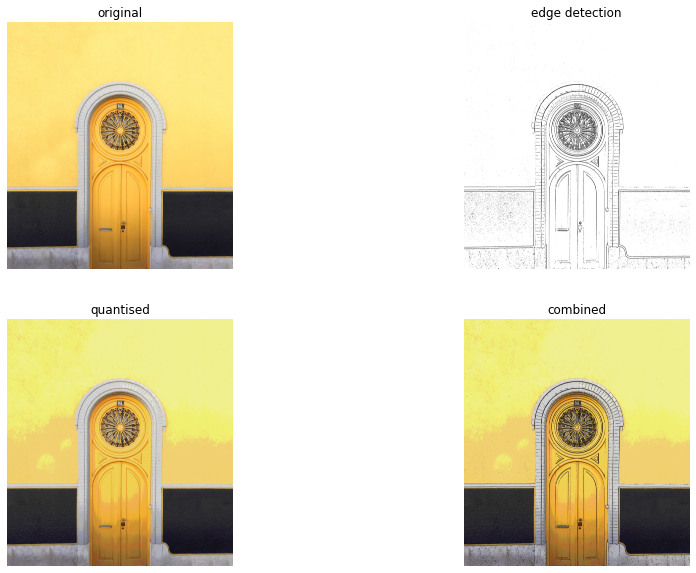

In [209]:
edges, quantise, combined = cartoonify(door, 8)
display([door, edges, quantise, combined], ['original', 'edge detection', 'quantised', 'combined'])

## Exercise 4 - Frequency Domain Properties

Converting an image to the frequency domain displays the frequencies exhibited within the image in greyscale.  The amplitudes of the low frequency components end up being at the corners of the two-dimensional spectrum, while the high frequencies are at the center. The image is displayed in polar form with the spectrum shifted to place the zero at the centre of the image.

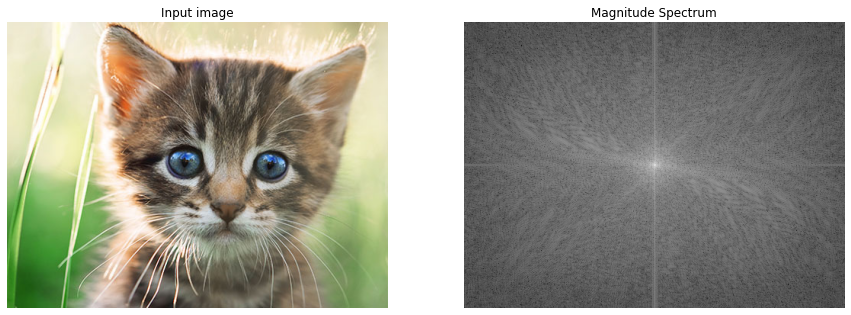

In [194]:
img_colour = cv2.imread('images/kitten.jpg')
img_colour = cv2.cvtColor(img_colour, cv2.COLOR_BGR2RGB)

img_grey = np.float32(cv2.imread('images/kitten.jpg', 0))
dft = cv2.dft(img_grey, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

display([img_colour, magnitude_spectrum],['Input image', 'Magnitude Spectrum'], cmap='gray')      

When the image is transformed by zero padding on once side to shift the image left, the shape of the fourier transform stays at the same shape as the image, however the transform itself does not change.  This is due to the fact that the imag

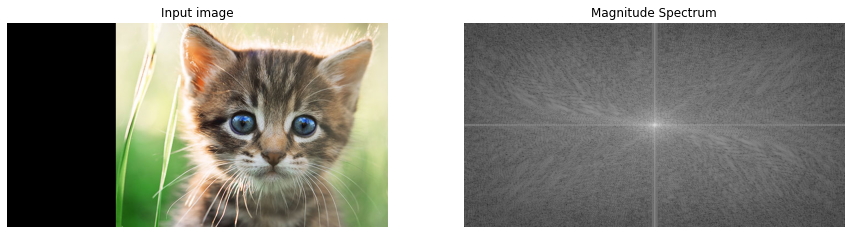

In [195]:
img_colour = cv2.imread('images/kitten.jpg')
img_colour = cv2.cvtColor(img_colour, cv2.COLOR_BGR2RGB)
img_colour = cv2.copyMakeBorder(img_colour, 0, 0, 200, 0, cv2.BORDER_CONSTANT, (0,0,0))

img_grey = cv2.imread('images/kitten.jpg', 0)
img_grey = cv2.copyMakeBorder(img_grey, 0, 0, 200, 0, cv2.BORDER_CONSTANT, (0,0,0))

f = cv2.dft(np.float32(img_grey), flags = cv2.DFT_COMPLEX_OUTPUT)
f = np.fft.fftshift(f)

magnitude_spectrum = 20*np.log(cv2.magnitude(f[:,:,0],f[:,:,1]))

display([img_colour, magnitude_spectrum],['Input image', 'Magnitude Spectrum'], cmap='gray')    

## Exercise 5 - Periodic Noise Removal

Using a sin function a noisy mask was created and overlaid over the original image. This was done by creating a matrix of values that increased over one axis, with the $sin$ of each element taken.  In this case the $y$ axis was chosen with the value multipled by a value $p$ before the $sin$ being taken.  The value of $p$ was chosen as a prime number (13 in this case) as this would be unlikely to cause multiple periodic changes in the rest of the image, as would occur for a value of 12, with multiple factors below.

$$
A_{original} = 
\begin{bmatrix}
v_{0,0} & v_{0,1} & ... & v_{0,n} \\
v_{0,1} & v_{1,1} & ... & \vdots\\
\vdots & & \ddots & \vdots\\
v_{m,0} & v_{m,1} & \dots & v_{m,n} 
\end{bmatrix}   
$$

$$
M = 
\begin{bmatrix}
sin(0p) & sin(1p) & ... & sin(np) \\
sin(0p) & sin(1p) & ... & \vdots\\
\vdots & & \ddots & \vdots\\
sin(0p) & sin(1p) & \cdots & sin(np) 
\end{bmatrix} 
$$

$$
\begin{equation}
A_{noisy} = A_{original} + M
\end{equation}
$$

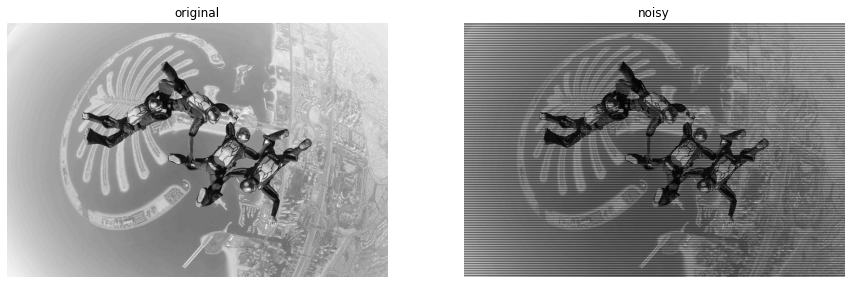

In [196]:
original = cv2.imread('images/hayabusa.jpg', 0)

x = range(np.shape(original)[0])
y = range(np.shape(original)[1])
xx, yy = np.meshgrid(y, x)

noise = np.abs(np.sin(yy * 13 ))
noisy = np.multiply(original, noise)

display([original, noisy],['original', 'noisy'], cmap='gray')

The noisy image clearly showing the periodic interference with the original at a high frequency (above).  The 2D Fourier Transform provides a clear indication of where the high frequency noise has been added in the additional spots on the magnitude spectrum along the centre line of the image. 

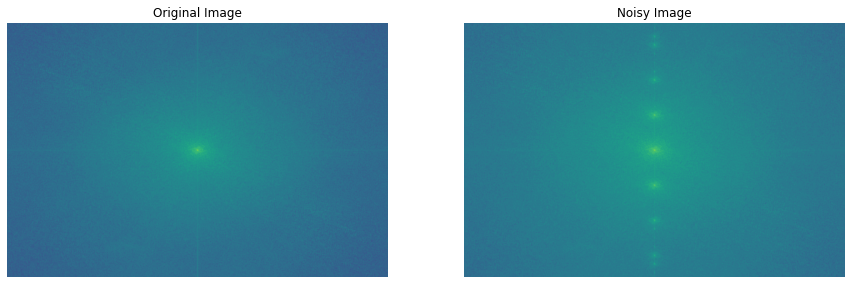

In [197]:
# Original Image FFT
f = np.fft.fftshift(np.fft.fft2(original))
original_magnitude_spectrum = 20 * np.log(np.abs(f))

# Noisy Image FFT
f = np.fft.fftshift(np.fft.fft2(noisy))
noisy_magnitude_spectrum = 20 * np.log(np.abs(f))

display([original_magnitude_spectrum, noisy_magnitude_spectrum],['Original Image', 'Noisy Image'])  

Taking the average amplitude across the Y axis gives a 2d plot where the exact frequencies can be identified at 99 and 976 Hz.  These appear as spikes either side of the main spike of the image.

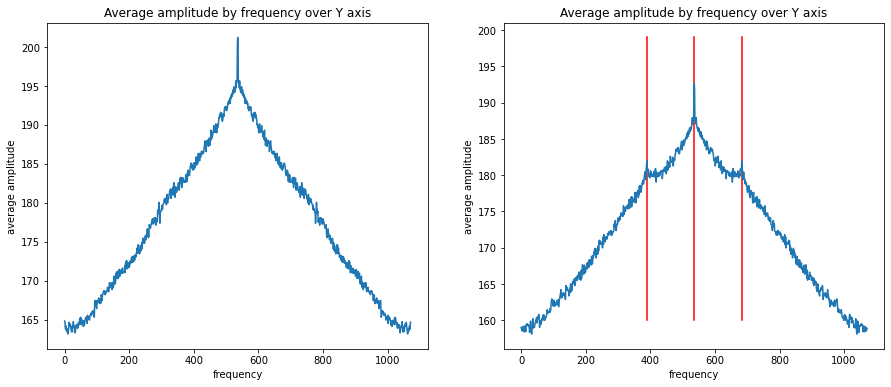

In [198]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1, 2, 1)
plt.plot(np.mean(original_magnitude_spectrum, axis=1))
plt.title('Average amplitude by frequency over Y axis')
plt.ylabel('average amplitude')
plt.xlabel('frequency');


fig.add_subplot(1, 2, 2)

# Plot noise points 
y = range(160, 200)
plt.plot(np.multiply(np.ones((len(y),)), 390), y, 'r')
plt.plot(np.multiply(np.ones((len(y),)), 535), y, 'r')
plt.plot(np.multiply(np.ones((len(y),)), 685), y, 'r')

# Plot Magnitude Spectrum
plt.plot(np.mean(noisy_magnitude_spectrum, axis=1))
plt.title('Average amplitude by frequency over Y axis')
plt.ylabel('average amplitude')
plt.xlabel('frequency');



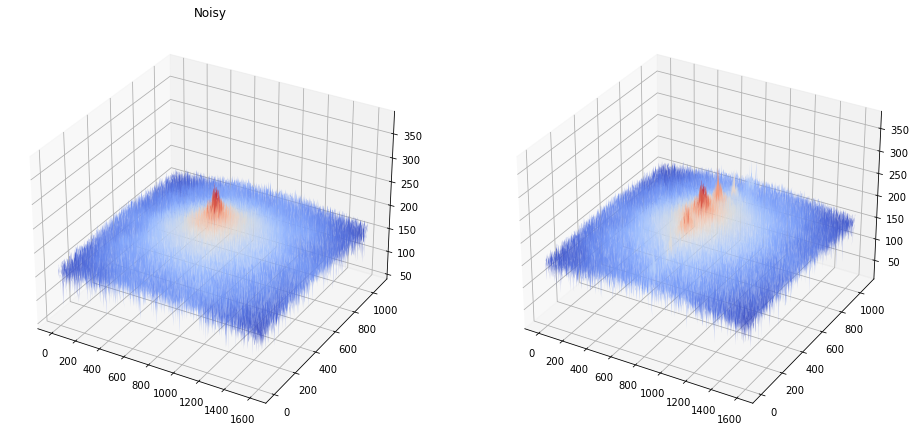

In [222]:
from mpl_toolkits.mplot3d import Axes3D

x, y = np.shape(original_magnitude_spectrum)
xx, yy = np.meshgrid(range(y), range(x))

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(xx, yy, original_magnitude_spectrum, cmap=plt.cm.coolwarm)
ax1.set_title("Original")

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(xx, yy, noisy_magnitude_spectrum, cmap=plt.cm.coolwarm)
ax1.set_title("Noisy");

A 3d rendering shows where the noise has been added as clearly as the 2d plot

The initial approach was to suppress the two isolated spikes by identifying the location and removing those frequencies with a high pass filter.  This was done by using two offset variables that would allow the filter to be located over the location to be suppressed and, by summing the two filters, would have the effect of suppressing the unwanted frequencies.

In [202]:
def visualize_filter(filter_mask):
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(filter_mask, cmap="gray")

    a2 = fig.add_subplot(1,2,2, projection="3d")
    x,y = np.meshgrid(np.arange(filter_mask.shape[0]),np.arange(filter_mask.shape[1]))
    a2.plot_surface(x,y,filter_mask.T,cmap=plt.cm.coolwarm,linewidth=0, antialiased=False)
    plt.show()

def idealLPF(d0, off1, off2, n1, n2, visualize = False):
    k1,k2 = np.meshgrid(np.arange(-round(n2/2)+1, math.floor(n2/2)+1), np.arange(-round(n1/2)+1, math.floor(n1/2)+1))
    d = np.sqrt((k1-off1)**2 + (k2-off2)**2)
    h = np.zeros((n1,n2))
    h[d < d0] = 1
    if visualize:
        visualize_filter(h)
    return h

def idealHPF(d0, off1, off2, n1, n2, visualize = False):
    k1,k2 = np.meshgrid(np.arange(-round(n2/2)+1, math.floor(n2/2)+1), np.arange(-round(n1/2)+1, math.floor(n1/2)+1))
    d = np.sqrt((k1-off1)**2 + (k2-off2)**2)
    h = np.zeros((n1,n2))
    h[d > d0] = 1
    if visualize:
        visualize_filter(h)
    return h

Two masks were created and can be seen to cover the spots on the magnitude plots, however the effect when applied was not significantly better, a clear improvement can be seen, however the noise is not fully removed.

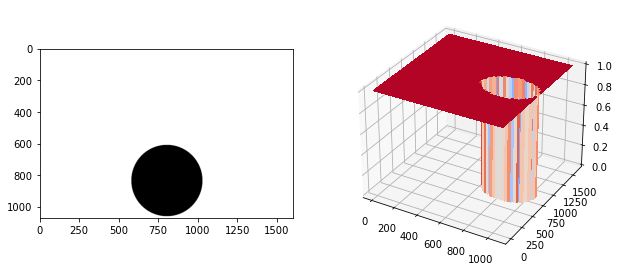

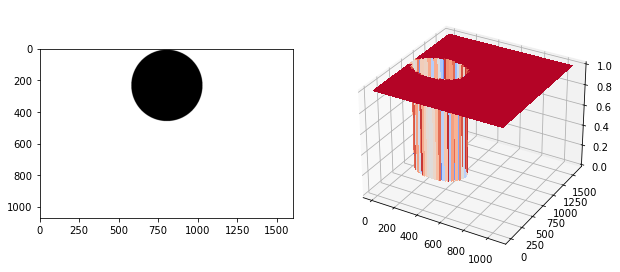

In [203]:
x = noisy_magnitude_spectrum.shape[0]
y = noisy_magnitude_spectrum.shape[1]

mask_1 = idealHPF(225, 0, 300, x, y, visualize=True)
mask_2 = idealHPF(225, 0,-300, x, y, visualize=True)

In [204]:
def apply_filter(img,filter_mask):
    f = np.fft.fftshift(np.fft.fft2(img))
    f1 = f * filter_mask
    magnitude_spectrum = 20 * np.log(np.abs(f1))
    x1 = np.fft.ifft2(np.fft.ifftshift(f1))

    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img,cmap="gray")
    ax1.set_title("Original")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(abs(x1)/255, cmap="gray")
    ax2.set_title("Filtered")
    ax2.axis('off')
    plt.show()
    return (magnitude_spectrum, img)

/tmp/ipykernel_12304/2519544494.py:4: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f1))


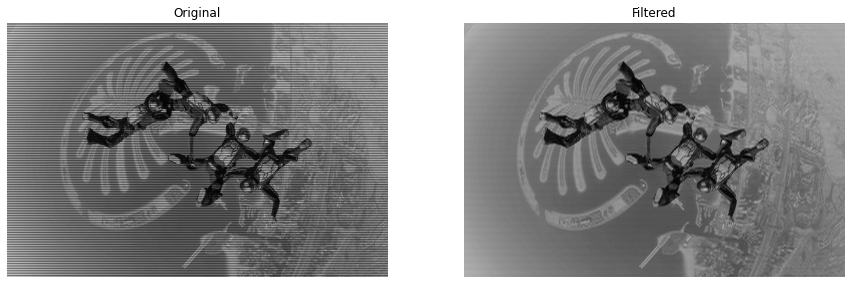

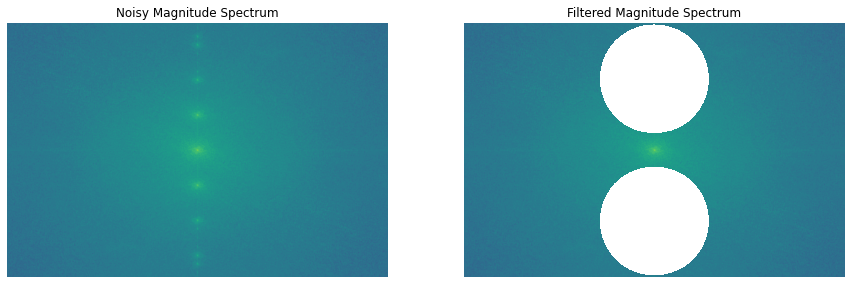

In [205]:
filtered_magnitude_spectrum, img = apply_filter(noisy, mask_1 * mask_2);
display([noisy_magnitude_spectrum, filtered_magnitude_spectrum],
        ['Noisy Magnitude Spectrum', 'Filtered Magnitude Spectrum']) 

Subsequently a single mask was made from an ideal low pass filter focused on the centre and removing all frequencies outside a very small radius.  This was manually tuned for best effect and proved to be a far better technique to remove the noise from the image.  

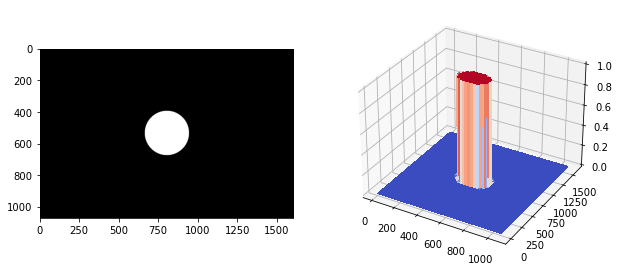

In [206]:
one_true_mask = idealLPF(140, 0, 0, x, y, visualize=True)

/tmp/ipykernel_12304/2519544494.py:4: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f1))


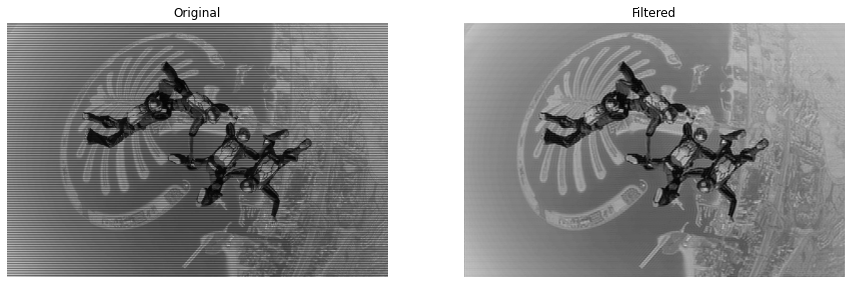

In [207]:
filtered_magnitude_spectrum, img = apply_filter(noisy, one_true_mask);

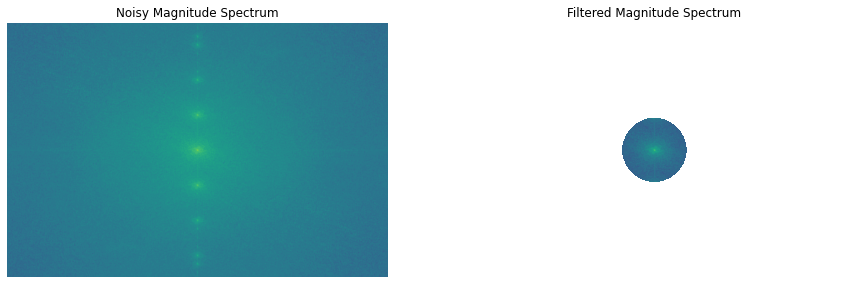

In [208]:
display([noisy_magnitude_spectrum, filtered_magnitude_spectrum],
        ['Noisy Magnitude Spectrum', 'Filtered Magnitude Spectrum'])  

### References

1. Open Source Computer Vision documentation: https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv


2. Polar Coordinate System: https://en.wikipedia.org/wiki/Polar_coordinate_system


3. Open Source Computer Vision, linearPolar: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gaa38a6884ac8b6e0b9bed47939b5362f3


4. Cartoonify: https://medium.com/nerd-for-tech/cartoonize-images-with-python-10e2a466b5fb